In [24]:
## import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from time import time

from imblearn.ensemble import BalanceCascade 
import csv

In [25]:
def get_subdata(data, size=10000):
    column = ['KORREKTUR']
    if data.KORREKTUR.dtype != np.float32:
        korrektur_vals = data[column].apply(lambda x: x.str.replace(',', '.'))[column[0]]
    else:
        korrektur_vals = data[column[0]]
    korrektur_vals = pd.to_numeric(korrektur_vals, downcast='float', errors='ignore')

    korrektur_df = pd.concat([data.ID, korrektur_vals], axis=1)

    target =  korrektur_df.drop_duplicates(subset=['ID'])[['ID', 'KORREKTUR']].reset_index(drop=True)
    N = len(target)

    ratio = np.sign(target.KORREKTUR).mean()
    n_samples = int(ratio * size)
    indices1 = np.random.choice(target[target.KORREKTUR>0].ID, size = n_samples, replace=False)
    indices0 = np.random.choice(target[target.KORREKTUR==0].ID, size = size - n_samples, replace=False)

    indices = np.append(indices0, indices1)
    return data.set_index('ID').loc[indices].reset_index()

In [26]:
%%time 
## import data
# DATA = pd.read_csv("../arzta_daten_anonym1.csv", sep=';')
# print(DATA.shape)

# DATA = get_subdata(DATA, size=10000)
# print(DATA.shape)

data1 = pd.read_csv("../Data_original/arzta_daten_anonym1.csv", sep=';')
data2 = pd.read_csv("../Data_original/arzta_daten_anonym2.csv", sep=';')
data3 = pd.read_csv("../Data_original/arzta_daten_anonym3.csv", sep=';')
data4 = pd.read_csv("../Data_original/arzta_daten_anonym4.csv", sep=';')
DATA = pd.concat([data1, data2, data3, data4], axis=0).reset_index(drop=True)

In [27]:
DATA.head()

,ID,KORREKTUR,RECHNUNGSBETRAG,ALTER,GESCHLECHT,VERSICHERUNG,FACHRICHTUNG,NUMMER,NUMMER_KAT,TYP,ANZAHL,FAKTOR,BETRAG,ART,LEISTUNG
0,ID_1,0,"330,97","53,5703841656576",0,1,1,A_178,AA_10,0.0,2,"2,3","24,4",NaN,C_1
1,ID_2,0,"455,2","83,3827191198588",1,1,1,A_765,AA_13,0.0,1,"1,15","2,01",NaN,C_6
2,ID_3,0,"199,53","69,5675107257784",1,1,1,A_1978,AA_2,0.0,1,"2,3","21,45",NaN,C_1
3,ID_4,0,"142,85","69,5563285223998",1,1,1,A_1257,AA_3,0.0,3,"2,3","32,16",NaN,C_1
4,ID_5,0,"168,87","18,8734340341816",0,1,1,A_737,AA_13,0.0,1,"1,15","3,35",NaN,C_6


* **Same** for each ID: *RECHNUNGSBETRAG, ALTER, GESCHLECHT, VERSICHERUNG == FACHRICHTUNG* (4)
* **Diff** for each ID: *NUMMER, NUMMER_KAT, ANZAHL, FAKTOR, BETRAG, ART, TYP, LEISTUNG* (8)

In [28]:
%%time 
## transfrom str type to float type
columns_comma = ['RECHNUNGSBETRAG', 'FAKTOR', 'BETRAG', 'ALTER', 'KORREKTUR'] 
DATA[columns_comma] = DATA[columns_comma].apply(lambda x: x.str.replace(',', '.'))
for column in columns_comma:
    DATA[column] = pd.to_numeric(DATA[column], downcast='float')

CPU times: user 13.5 s, sys: 745 ms, total: 14.3 s
Wall time: 14.3 s


In [29]:
%%time
## construct target column
target = DATA.groupby(['ID'])['KORREKTUR'].apply(lambda dt: int(np.sign(dt).values[0])).to_frame(name='target')
DATA = DATA.merge(target, on='ID', how='inner')

CPU times: user 46.4 s, sys: 522 ms, total: 46.9 s
Wall time: 46.9 s


In [30]:
## DATA must be sorted by Id
current_id = ''
indices = []

for i, Id in enumerate(DATA.ID):
    if Id != current_id:
        if i > 0: 
            indices.append(current_index)
        current_id = Id
        current_index = [i]
    else:
        current_index.append(i)
        
indices.append(current_index)

### BETRAG, ANZAHL: mean, std, min, max, median

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


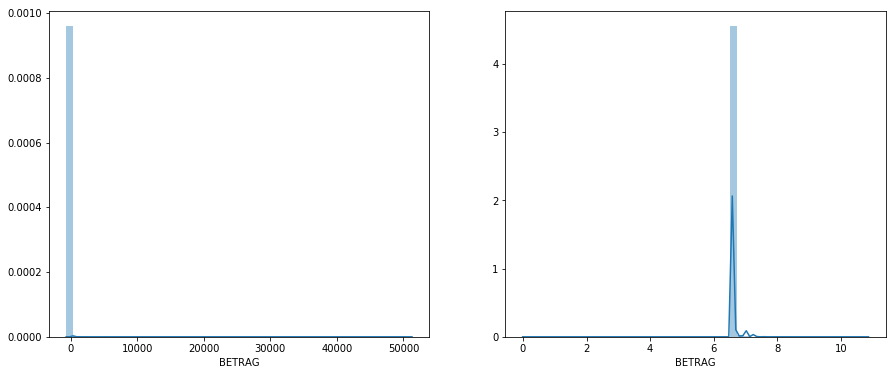

In [31]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.distplot(DATA.BETRAG)
plt.subplot(122)
sns.distplot(np.log(DATA.BETRAG  - DATA.BETRAG.min() + 1));

In [32]:
# BETRAG / ANZAHL (prices for one treatment) 
vals = DATA.BETRAG / DATA.ANZAHL
DATA.BETRAG = np.log(vals - np.min(vals, 0) +  1)

In [33]:
%%time
# construct mean and std values for each ID
betrag_mean = DATA.groupby(['ID'])['BETRAG'].mean()
betrag_std = DATA.groupby(['ID'])['BETRAG'].std().fillna(0)
betrag_min = DATA.groupby(['ID'])['BETRAG'].min()
betrag_max = DATA.groupby(['ID'])['BETRAG'].max()
betrag_median = DATA.groupby(['ID'])['BETRAG'].median()

betrag_all = pd.concat([betrag_mean, betrag_std, betrag_min, betrag_max, betrag_median], axis=1, keys=
          ['BETRAG_mean', 'BETRAG_std', 'BETRAG_min', 'BETRAG_max', 'BETRAG_median']).reset_index()

CPU times: user 5.76 s, sys: 171 ms, total: 5.93 s
Wall time: 5.93 s


In [34]:
betrag_all.head()

,ID,BETRAG_mean,BETRAG_std,BETRAG_min,BETRAG_max,BETRAG_median
0,ID_1,5.536996,0.099091,5.472971,5.733492,5.503764
1,ID_10,5.451298,0.024179,5.432790,5.498015,5.438630
2,ID_100,5.456017,0.039757,5.426916,5.569514,5.438630
3,ID_1000,5.492091,0.049110,5.428058,5.551434,5.486863
4,ID_10000,5.447095,0.020787,5.432790,5.498015,5.438630


In [35]:
%%time
betrag_data = []
start = time()
ticks = np.linspace(2, 6, 100)
ids = DATA.ID.unique()
for i, Id in enumerate(ids):
    indices[i]
    betrag_data.append(np.histogram(DATA.iloc[indices[i]]['BETRAG'], ticks)[0])
    if i % 3000 == 0: 
        print(i, 'Done', np.round(i / len(ids) * 100, 2) , '% time:', time() - start)    

betrag_data = pd.DataFrame(betrag_data, columns = ['betrag' + str(np.round(val, 2)) for val in ticks[:-1]])
betrag_data = pd.concat([pd.Series(ids, name='ID'), betrag_data], axis=1)

0 Done 0.0 % time: 0.6383719444274902
3000 Done 0.79 % time: 2.3450393676757812
6000 Done 1.57 % time: 4.049139738082886
9000 Done 2.36 % time: 5.759040355682373
12000 Done 3.15 % time: 7.47232985496521
15000 Done 3.94 % time: 9.178642511367798
18000 Done 4.72 % time: 10.884702444076538
21000 Done 5.51 % time: 12.582927227020264
24000 Done 6.3 % time: 14.28868293762207
27000 Done 7.09 % time: 15.98817491531372
30000 Done 7.87 % time: 17.710964918136597
33000 Done 8.66 % time: 19.418649196624756
36000 Done 9.45 % time: 21.121113061904907
39000 Done 10.24 % time: 22.82325053215027
42000 Done 11.02 % time: 24.54296612739563
45000 Done 11.81 % time: 26.261221885681152
48000 Done 12.6 % time: 27.98338484764099
51000 Done 13.39 % time: 29.698882579803467
54000 Done 14.17 % time: 31.418498992919922
57000 Done 14.96 % time: 33.12955069541931
60000 Done 15.75 % time: 34.830721855163574
63000 Done 16.53 % time: 36.554789543151855
66000 Done 17.32 % time: 38.296531200408936
69000 Done 18.11 % tim

In [36]:
betrag_data.head()

,ID,betrag2.0,betrag2.04,betrag2.08,betrag2.12,betrag2.16,betrag2.2,betrag2.24,betrag2.28,betrag2.32,...,betrag5.6,betrag5.64,betrag5.68,betrag5.72,betrag5.76,betrag5.8,betrag5.84,betrag5.88,betrag5.92,betrag5.96
0,ID_1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ID_2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,ID_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ID_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ID_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### FAKTOR: mean, std, min, max, median

In [37]:
%%time
# construct mean and std values for each ID
faktor_mean = DATA.groupby(['ID'])['FAKTOR'].mean()
faktor_std = DATA.groupby(['ID'])['FAKTOR'].std().fillna(0)
faktor_min = DATA.groupby(['ID'])['FAKTOR'].min()
faktor_max = DATA.groupby(['ID'])['FAKTOR'].max()
faktor_median = DATA.groupby(['ID'])['FAKTOR'].median()

faktor_all = pd.concat([faktor_mean, faktor_std, faktor_min, faktor_max, faktor_median], axis=1, keys=
          ['FAKTOR_mean', 'FAKTOR_std', 'FAKTOR_min', 'FAKTOR_max', 'FAKTOR_median']).reset_index()

CPU times: user 5.28 s, sys: 41 ms, total: 5.32 s
Wall time: 5.32 s


In [38]:
faktor_all.head()

,ID,FAKTOR_mean,FAKTOR_std,FAKTOR_min,FAKTOR_max,FAKTOR_median
0,ID_1,2.533333,0.480278,2.30,3.50,2.300
1,ID_10,1.150000,0.000000,1.15,1.15,1.150
2,ID_100,1.154286,0.728351,0.00,2.30,1.150
3,ID_1000,1.430000,0.918695,0.00,2.30,1.475
4,ID_10000,1.082353,0.278916,0.00,1.15,1.150


### TYP: mean, std, min, max, median

In [39]:
%%time
# construct mean and std values for each ID
DATA.TYP.fillna(-1, inplace=True)
typ_mean = DATA.groupby(['ID'])['TYP'].mean()
typ_std = DATA.groupby(['ID'])['TYP'].std().fillna(0)
typ_min = DATA.groupby(['ID'])['TYP'].min()
typ_max = DATA.groupby(['ID'])['TYP'].max()
typ_median = DATA.groupby(['ID'])['TYP'].median()

typ_all = pd.concat([typ_mean, typ_std, typ_min, typ_max, typ_median], axis=1, keys=
          ['TYP_mean', 'TYP_std', 'TYP_min', 'TYP_max', 'TYP_median']).reset_index()

CPU times: user 5.24 s, sys: 24.7 ms, total: 5.26 s
Wall time: 5.26 s


In [40]:
typ_all.head()

,ID,TYP_mean,TYP_std,TYP_min,TYP_max,TYP_median
0,ID_1,0.000000,0.000000,0.0,0.0,0.0
1,ID_10,0.000000,0.000000,0.0,0.0,0.0
2,ID_100,-0.200000,0.405840,-1.0,0.0,0.0
3,ID_1000,-0.200000,0.421637,-1.0,0.0,0.0
4,ID_10000,-0.058824,0.242536,-1.0,0.0,0.0


### NUMMER, NUMMER_KAT, LEISTUNG, ART. Encode all treatments and their categories

In [41]:
%%time

nummer_list = []
nummer_kat_list = []
leistung_list = []
art_list = []

start = time()
ids = DATA.ID.unique()
for i, Id in enumerate(ids):
    
    nummer_counter = DATA.iloc[indices[i]]['NUMMER'].value_counts()
    nummer_kat_counter = DATA.iloc[indices[i]]['NUMMER_KAT'].value_counts()
    leistung_counter = DATA.iloc[indices[i]]['LEISTUNG'].value_counts()
    art_counter = DATA.iloc[indices[i]]['ART'].value_counts()

    nummer_list.append(dict(nummer_counter))
    nummer_kat_list.append(dict(nummer_kat_counter))
    leistung_list.append(dict(leistung_counter))
    art_list.append(dict(art_counter))
    
    if i % 3000 == 0: 
        print(i, 'Done', np.round(i / len(ids) * 100, 2) , '% time:', time() - start)    

0 Done 0.0 % time: 0.6755530834197998
3000 Done 0.79 % time: 15.008055448532104
6000 Done 1.57 % time: 29.392253637313843
9000 Done 2.36 % time: 43.68917655944824
12000 Done 3.15 % time: 57.983036279678345
15000 Done 3.94 % time: 72.26187014579773
18000 Done 4.72 % time: 86.56166219711304
21000 Done 5.51 % time: 101.0933244228363
24000 Done 6.3 % time: 115.40189266204834
27000 Done 7.09 % time: 129.7186255455017
30000 Done 7.87 % time: 144.03392219543457
33000 Done 8.66 % time: 158.2939133644104
36000 Done 9.45 % time: 172.5446436405182
39000 Done 10.24 % time: 186.79854583740234
42000 Done 11.02 % time: 201.15327954292297
45000 Done 11.81 % time: 215.46861481666565
48000 Done 12.6 % time: 229.86006236076355
51000 Done 13.39 % time: 244.07618737220764
54000 Done 14.17 % time: 258.39608454704285
57000 Done 14.96 % time: 272.7076964378357
60000 Done 15.75 % time: 286.9331216812134
63000 Done 16.53 % time: 301.31279826164246
66000 Done 17.32 % time: 315.69835233688354
69000 Done 18.11 % t

In [42]:
%%time 
nummer_df = pd.DataFrame(nummer_list).to_sparse()
nummer_kat_df = pd.DataFrame(nummer_kat_list).to_sparse()
leistung_df = pd.DataFrame(leistung_list).to_sparse()
art_df = pd.DataFrame(art_list).to_sparse()

CPU times: user 2min 7s, sys: 5.93 s, total: 2min 13s
Wall time: 2min 13s


## Construct new DataFrame

In [43]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve

def plot_confusion_matrix(prediction, y_test):
    plt.figure(figsize=(15, 6))
    c_matrix = confusion_matrix(y_test, prediction)
    c_matrix_ = np.round(100 * c_matrix / c_matrix.sum(axis=1).reshape(-1, 1))
    plt.subplot(121)
    sns.heatmap(c_matrix, annot=True, fmt="d");
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.subplot(122)
    sns.heatmap(np.asarray(c_matrix_, dtype=int), annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_roc_auc_score(prediction, y_test):
    value = np.round(roc_auc_score(y_test, prediction[:,1]),4)
    print('ROC AUC score:',  value)
    
    return value

def get_pr_auc_score(prediction, y_test):
    value = np.round(average_precision_score(y_test, prediction[:, 1]),4)
    print('PR AUC score:',  value)
    
    return value
    
def plot_curves(prediction, y_test):
    tpr, fpr, _ = roc_curve(y_test, prediction[:,1])
    roc_auc = roc_auc_score(y_test, prediction[:,1])
    
    precision, recall, _ = precision_recall_curve(y_test, prediction[:,1])
    average_precision = average_precision_score(y_test, prediction[:,1])

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.step(tpr, fpr, color='b', alpha=0.2, where='post')
    plt.fill_between(tpr, fpr, step='post', alpha=0.2, color='b')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class ROC curve: ROC AUC={0:0.2f}'.format(roc_auc))

    plt.subplot(122)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
def get_threshold_by_f1(prediction_proba, y_test, plot=False):
    thresholds = np.linspace(prediction_proba[:, 1].min(), prediction_proba[:, 1].max(), 300)
    curve = []
    for val in thresholds:
       
        prediction = np.asarray((prediction_proba[:, 1] >= val), int)
        curve.append(f1_score(prediction, y_test))

    argmax = np.argmax(curve)

    if plot == True:
        plt.figure(figsize=(14, 4))
        plt.plot(thresholds, curve)
        plt.plot([thresholds[argmax]] * 2, [np.min(curve), np.max(curve)])
    
    return thresholds[argmax]

def plot_probas(prediction_proba, y_test):
    plt.figure(figsize=(14, 4))
    probas = prediction_proba[:, 1]
    ax = sns.distplot(probas)
    proba_mean = probas.mean()
    proba_f1_best = get_threshold_by_f1(prediction_proba, y_test)
    plt.plot([proba_mean] * 2, ax.get_ylim(), label='Mean of probabilites')
    plt.plot([proba_f1_best] * 2, ax.get_ylim(), label='Best threshold by f1 score')
    plt.legend(fontsize=16)

In [44]:
DATA.RECHNUNGSBETRAG = np.log(DATA.RECHNUNGSBETRAG - np.min(DATA.RECHNUNGSBETRAG, 0) +  1)

In [45]:
data = DATA.drop_duplicates(subset=['ID'])[['ID', 'RECHNUNGSBETRAG', 'ALTER', 'GESCHLECHT', 'VERSICHERUNG', 'target']].reset_index(drop=True)

data = data.merge(betrag_all, on='ID', how='inner')
data = data.merge(betrag_data, on='ID', how='inner')
data = data.merge(typ_all, on='ID', how='inner')
data = data.merge(faktor_all, on='ID', how='inner')

data.head()

,ID,RECHNUNGSBETRAG,ALTER,GESCHLECHT,VERSICHERUNG,target,BETRAG_mean,BETRAG_std,BETRAG_min,BETRAG_max,...,TYP_mean,TYP_std,TYP_min,TYP_max,TYP_median,FAKTOR_mean,FAKTOR_std,FAKTOR_min,FAKTOR_max,FAKTOR_median
0,ID_1,5.803356,53.570385,0,1,0,5.536996,0.099091,5.472971,5.733492,...,0.000000,0.000000,0.0,0.0,0.0,2.533333,0.480278,2.3,3.5,2.30
1,ID_2,6.121703,83.382721,1,1,0,5.467100,0.056505,5.426916,5.657517,...,-0.024390,0.156174,-1.0,0.0,0.0,1.520732,0.697852,0.0,3.5,1.15
2,ID_3,5.298167,69.567513,1,1,0,5.479981,0.039245,5.430208,5.551550,...,-0.153846,0.375534,-1.0,0.0,0.0,2.015385,0.968544,0.0,3.5,2.30
3,ID_4,4.964870,69.556328,1,1,0,5.484001,0.034666,5.429989,5.538344,...,-0.111111,0.333333,-1.0,0.0,0.0,2.066667,0.917878,0.0,3.5,2.30
4,ID_5,5.131732,18.873434,0,1,0,5.468701,0.032851,5.429989,5.538344,...,-0.076923,0.277350,-1.0,0.0,0.0,1.873077,0.857714,0.0,3.5,2.30


In [46]:
%%time 

data = pd.concat([data, nummer_df], axis=1)
data = pd.concat([data, nummer_kat_df], axis=1)
data = pd.concat([data, leistung_df], axis=1)
data = pd.concat([data, art_df], axis=1)

data.fillna(0, inplace=True)

CPU times: user 1.42 s, sys: 895 ms, total: 2.31 s
Wall time: 2.31 s


In [47]:
data.to_pickle('../TransformedFullData.pkl')

In [ ]:
def save_csv(data):
    batch_size = 100
    data_size = int(len(data) / (batch_size - 1))

    start = time()
    for i in range(batch_size):
        batch = data.iloc[i * data_size : (i + 1) * data_size]
        if i == 0:    
            batch.to_csv('TransformedData.csv', index=False)
        else:
            with open('TransformedData.csv', 'a') as csvFile:
                writer = csv.writer(csvFile)
                writer.writerows(batch.values)

            csvFile.close()
        print(i, 'Done,', ' time:', time() - start)
        
def read_csv(filename='TransformedData.csv'):
    chunksize = 10000
    chunks = pd.read_csv(filename, chunksize=chunksize)

    data = []
    start = time()
    for i, chunk in enumerate(chunks):
        data.append(chunk.to_sparse())
        print(i, 'Done,', ' time:', time() - start)

    return pd.concat(data)